#                                            In The Name OF GOD

## Unsteady one-dimentional heat transfer in Prismatic fins

______________________________________________________________________________________________________

#### Alireza Rezaeishaker

#### These homework was done by ARRSH

#### Departeman of Mechanical Engineering

#### Amirkabir Univercity of Technology

## problem statement

Unsteady one-dimentional heat transfer in Prismatic fins is governed by the following equation:

\begin{alignat}{1}
	& \dfrac{\partial \theta}{\partial t} = \alpha \dfrac{\partial^2 \theta}{\partial x^2} - Bi A_r \alpha \theta
\end{alignat}

that,

\begin{alignat}{1}
& A_r = \dfrac{hP}{A}
\end{alignat}

\begin{alignat}{1}
& Bi = \dfrac{hL}{k}
\end{alignat}

\begin{alignat}{1}
& \theta = \dfrac{ T-T_{\infty}}{ T_0-T_{\infty}}
\end{alignat}

\begin{alignat}{1}
& \mu^2 = A_rBi
\end{alignat}

## Discretization

all discretizations are Second-order in space and time

\begin{alignat}{1}
& Fo = \dfrac{\alpha\Delta t}{L^2}
\end{alignat}

\begin{alignat}{1}
& v = \dfrac{Fo}{(\Delta x)^2}
\end{alignat}

\begin{alignat}{1}
& w = BiFoA_r
\end{alignat}

### Discretization with FTCS

\begin{alignat}{1}
\theta_{i,j+1} = v\theta_{i,j-1} + \left(1-w+2v\right)\theta_{i,j} + v\theta_{i,j+1}
\end{alignat}

### Discretization with BTCS

\begin{alignat}{1}
-\theta_{i,j} = v\theta_{i-1,j+1} - \left(1+w+2v\right)\theta_{i,j+1} + v\theta_{i+1,j+1}
\end{alignat}

### Discretization with CTCS

\begin{alignat}{1}
\theta_{i,j+2} = 2v\theta_{i-1,j+1} - \left(2w+4v\right)\theta_{i,j+1} + 2v\theta_{i+1,j+1} + \theta_{i,j}
\end{alignat}

### Discretization with Crank-Nicelson

\begin{alignat}{1}
\dfrac{v}{2}\theta_{i-1,j+1} - \left(1+\dfrac{w}{2}+v\right)\theta_{i,j+1} + \dfrac{v}{2}\theta_{i+1,j+1} = 
-\left(\dfrac{v}{2}\theta_{i-1,j} + \left(1-\dfrac{w}{2}-v\right)\theta_{i,j} + \dfrac{v}{2}\theta_{i+1,j}\right)
\end{alignat}

### Discretization of Boundary conditions

\begin{alignat}{1}
\theta_{0,j} = 1
\end{alignat}

\begin{alignat}{1}
\theta_{i,0} = 0
\end{alignat}


\begin{alignat}{1}
\left(2 + 2Bi\Delta x + \left(\mu \Delta x\right)^2\right)\theta_{n,j} - 2\theta_{n-1,j}  = 0
\end{alignat}

## Define Functions Discretizations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import sparse
import scipy.sparse.linalg as spla
Bi = 0.1
A_r = 20
alpha = 17*1e-6

### FTCS

In [2]:
def generate_le_FTCS(nx,nt,alpha,A_r,Bi):
    
    def dx(nx):
        dx = 1/(nx-1)
        return dx
    def dt(nt):
        dt = 10/(nt-1)
        return dt
    
    def initialize_variables(nx,dx,dt):
        I = np.zeros(nx+1)
        J = np.zeros(nx+1)
        V = np.zeros(nx+1)
        B = np.zeros(nx)
        theta = np.zeros(nx)
        Fo = alpha*dt
        w = Bi*Fo*A_r
        v = Fo/(dx**2)
        return I, J, V, B, theta,v, w
    
    def initialize_coeffs(I,J,V,B,nx,dx,dt,alpha,A_r,Bi):
        for i in range(1,nx):
            k = (i-1) + 1
            I[k] = int(i)
            J[k] = int(i)
            V[k] = 1
        Fo = alpha*dt
        w = Bi*Fo*A_r
        v = Fo/(dx**2)
        for i in range(1,nx-2):
            B[i] = v*theta[i-1]+(1-(w+2*v))*theta[i]+v*theta[i+1]
            
    def left_bc (I,J,V,B,n,dx):
        I[0] = 0
        J[0] = 0
        V[0] = 1
        B[0] = 1
    
    def right_bc (I,J,V,nx,dx,Bi):
        I[nx-1:nx+1] = nx-1
        J[nx-1:nx+1] = (nx-2, nx-1)
        m = Bi*A_r
        V[nx-1:nx+1] = (-2, 2+2*Bi*dx+m*(dx)**2)
        bc = (left_bc, right_bc)
        
    bc = (left_bc, right_bc)
    
    dx = dx(nx)
    dt = dt(nt)
    lbc, rbc = bc
    I,J,V,B,theta,v,w = initialize_variables(nx,dx,dt)
    initialize_coeffs(I,J,V,B,nx,dx,dt,alpha,A_r,Bi)
    lbc(I,J,V,B,nx,dx)
    rbc(I,J,V,nx,dx,Bi)
    return sparse.csc_matrix((V,(I,J)),shape=(nx,nx)), B, theta, v, w

def FTCS_solver(nx,nt,alpha,A_r,Bi):
    dz = np.linspace(0,1,nx)
    A,B,theta,v,w = generate_le_FTCS(nx,nt,alpha,A_r,Bi)
    
#     def counter(rk=None):
#         counter.niter += 1
#         print("# iter {:3d}, residual = {}".format(counter.niter,str(rk)))
        
    A2 = A
    M2 = spla.spilu(A2,fill_factor=10) # fill ratio upper bound
    M_x = lambda x: M2.solve(x)
    M = spla.LinearOperator((nx,nx), M_x)
#     counter.niter = 0
    j = 0
    while(j<=nt):
        theta = spla.gmres(A2,B,tol=1e-6,M=M)[0]
        for i in range(1,nx-1):
            B[i] = v*theta[i-1]+(1-(w+2*v))*theta[i]+v*theta[i+1]
#         print(B)
        j = j+1
    return dz, theta

### BTCS

In [3]:
def generate_le_BTCS(nx,nt,Bi):
    
    def initialize_variables(nx,dx,dt):
        I = np.zeros(3*(nx-1))
        J = np.zeros(3*(nx-1))
        V = np.zeros(3*(nx-1))
        B = np.zeros(nx)
        theta = np.zeros(nx)
        Fo = alpha*dt
        w = Bi*Fo*A_r
        v = Fo/(dx**2)
        return I, J, V, B, theta,v, w

    def dx(nx):
        dx = 1/(nx-1)
        return dx
    
    def dt(nt):
        dt = 10/(nt-1)
        return dt
    

    def initialize_coeffs(I,J,V,nx,dx,alpha,dt):
        for i in range(1,nx-1):
            k = 3*(i-1) + np.linspace(1,4,3)
            Fo = alpha*dt
            w = Bi*Fo*A_r
            v = Fo/(dx**2)
            I[int(k[0]):int(k[-1])] = int(i)
            J[int(k[0]):int(k[-1])] = (i-1, i, i+1)
            V[int(k[0]):int(k[-1])] = (v, -(1+(w+2*v)), v)
        
        
    def left_bc (I,J,V,B,nx,dx):
        k = np.linspace(0,1,2)
        I[0] = 0
        J[0] = 0
        V[0] = 1
        B[0] = 1
    
    def right_bc (I,J,V,nx,dx,Bi):
        k = (3*(nx-1)-2) + np.linspace(0,1,2)
        I[int(k[0]):int(k[-1])+1] = nx-1
        J[int(k[0]):int(k[-1])+1] = (nx-2, nx-1)
        m = Bi*A_r
        V[int(k[0]):int(k[-1])+1] = (-2, 2+2*Bi*dx+m*(dx)**2)
        
    bc = (left_bc, right_bc)
    
    dx = dx(nx)
    dt = dt(nt)
    lbc, rbc = bc
    I,J,V,B,theta,v,w = initialize_variables(nx,dx,dt)
    initialize_coeffs(I,J,V,nx,dx,alpha,dt)
    lbc(I,J,V,B,nx,dx)
    rbc(I,J,V,nx,dx,Bi)
    return sparse.csc_matrix((V,(I,J)),shape=(nx,nx)), B, theta, v, w


def BTCS_solver(nx,nt,alpha,A_r,Bi):
    dz = np.linspace(0,1,nx)
    A,B,theta,v,w = generate_le_BTCS(nx,nt,Bi)
    
#     def counter(rk=None):
#         counter.niter += 1
#         print("# iter {:3d}, residual = {}".format(counter.niter,str(rk)))
        
    A2 = A
    M2 = spla.spilu(A2,fill_factor=10) # fill ratio upper bound
    M_x = lambda x: M2.solve(x)
    M = spla.LinearOperator((nx,nx), M_x)
#     counter.niter = 0
    j = 0
    while(j<=nt):
        theta = spla.gmres(A2,B,tol=1e-6,M=M)[0]
        B[1] = -(v+theta[1])
        for i in range(2,nx-1):
            B[i] = -theta[i]
#         print(B)
        j = j+1
    return dz, theta

### CTCS

In [4]:
def generate_le_CTCS(nx,nt,alpha,A_r,Bi):
    
    def dx(nx):
        dx = 1/(nx-1)
        return dx
    def dt(nt):
        dt = 10/(nt-1)
        return dt
    
    def initialize_variables(nx,dx,dt):
        I = np.zeros(nx+1)
        J = np.zeros(nx+1)
        V = np.zeros(nx+1)
        B = np.zeros(nx)
        theta = np.zeros((2,nx))
        Fo = alpha*dt
        w = Bi*Fo*A_r
        v = Fo/(dx**2)
        return I, J, V, B, theta,v, w
    
    def initialize_coeffs(I,J,V,B,nx,dx,dt,alpha,A_r,Bi):
        for i in range(1,nx):
            k = (i-1) + 1
            I[k] = int(i)
            J[k] = int(i)
            V[k] = 1
        Fo = alpha*dt
        w = Bi*Fo*A_r
        v = Fo/(dx**2)
#         for i in range(1,nx-2):
#             B[i] = v*theta[i-1]+(1-(w+2*v))*theta[i]+v*theta[i+1]
            
    def left_bc (I,J,V,B,n,dx):
        I[0] = 0
        J[0] = 0
        V[0] = 1
        B[0] = 1
    
    def right_bc (I,J,V,nx,dx,Bi):
        I[nx-1:nx+1] = nx-1
        J[nx-1:nx+1] = (nx-2, nx-1)
        m = Bi*A_r
        V[nx-1:nx+1] = (-2, 2+2*Bi*dx+m*(dx)**2)
        bc = (left_bc, right_bc)
        
    bc = (left_bc, right_bc)
    
    dx = dx(nx)
    dt = dt(nt)
    lbc, rbc = bc
    I,J,V,B,theta,v,w = initialize_variables(nx,dx,dt)
    initialize_coeffs(I,J,V,B,nx,dx,dt,alpha,A_r,Bi)
    lbc(I,J,V,B,nx,dx)
    rbc(I,J,V,nx,dx,Bi)
    return sparse.csc_matrix((V,(I,J)),shape=(nx,nx)), B, theta, v, w


def CTCS_solver(nx,nt,alpha,A_r,Bi):
    dz = np.linspace(0,1,nx)
    A,B,theta,v,w = generate_le_CTCS(nx,nt,alpha,A_r,Bi)
    
#     def counter(rk=None):
#         counter.niter += 1
#         print("# iter {:3d}, residual = {}".format(counter.niter,str(rk)))
        
    A2 = A
    M2 = spla.spilu(A2,fill_factor=10) # fill ratio upper bound
    M_x = lambda x: M2.solve(x)
    M = spla.LinearOperator((nx,nx), M_x)
#     counter.niter = 0
    j = 0
    theta[1,:] = spla.gmres(A2,B,tol=1e-6,M=M)[0]
    for i in range(1,nx-1):
        B[i] = theta[0,i] +  2*v*theta[1,i-1]-(4*v+2*w)*theta[1,i]+2*v*theta[1,i+1]   
    while(j<=nt):
        theta[0,:] = theta[1,:]
        theta[1,:] = spla.gmres(A2,B,tol=1e-6,M=M)[0]
        for i in range(1,nx-1):
            B[i] = theta[0,i] +  2*v*theta[1,i-1]-(4*v+2*w)*theta[1,i]+2*v*theta[1,i+1]
        j = j+1
    return dz, theta[1,:]

### Crank-Nicelson(CN)

In [5]:
def generate_le_CN(nx,nt,Bi):
    
    def initialize_variables(nx,dx,dt):
        I = np.zeros(3*(nx-1))
        J = np.zeros(3*(nx-1))
        V = np.zeros(3*(nx-1))
        B = np.zeros(nx)
        theta = np.zeros(nx)
        Fo = alpha*dt
        w = Bi*Fo*A_r
        v = Fo/(dx**2)
        return I, J, V, B, theta,v, w

    def dx(nx):
        dx = 1/(nx-1)
        return dx
    
    def dt(nt):
        dt = 10/(nt-1)
        return dt
    

    def initialize_coeffs(I,J,V,nx,dx,alpha,dt):
        for i in range(1,nx-1):
            k = 3*(i-1) + np.linspace(1,4,3)
            Fo = alpha*dt
            w = Bi*Fo*A_r
            v = Fo/(dx**2)
            I[int(k[0]):int(k[-1])] = int(i)
            J[int(k[0]):int(k[-1])] = (i-1, i, i+1)
            V[int(k[0]):int(k[-1])] = (v/2, -(1+((w/2)+v)), v/2)
        
        
    def left_bc (I,J,V,B,nx,dx):
        k = np.linspace(0,1,2)
        I[0] = 0
        J[0] = 0
        V[0] = 1
        B[0] = 1
    
    def right_bc (I,J,V,nx,dx,Bi):
        k = (3*(nx-1)-2) + np.linspace(0,1,2)
        I[int(k[0]):int(k[-1])+1] = nx-1
        J[int(k[0]):int(k[-1])+1] = (nx-2, nx-1)
        m = Bi*A_r
        V[int(k[0]):int(k[-1])+1] = (-2, 2+2*Bi*dx+m*(dx)**2)
        
    bc = (left_bc, right_bc)
    
    dx = dx(nx)
    dt = dt(nt)
    lbc, rbc = bc
    I,J,V,B,theta,v,w = initialize_variables(nx,dx,dt)
    initialize_coeffs(I,J,V,nx,dx,alpha,dt)
    lbc(I,J,V,B,nx,dx)
    rbc(I,J,V,nx,dx,Bi)
    return sparse.csc_matrix((V,(I,J)),shape=(nx,nx)), B, theta, v, w


def CN_solver(nx,nt,alpha,A_r,Bi):
    dz = np.linspace(0,1,nx)
    A,B,theta,v,w = generate_le_CN(nx,nt,Bi)
    
#     def counter(rk=None):
#         counter.niter += 1
#         print("# iter {:3d}, residual = {}".format(counter.niter,str(rk)))
        
    A2 = A
    M2 = spla.spilu(A2,fill_factor=10) # fill ratio upper bound
    M_x = lambda x: M2.solve(x)
    M = spla.LinearOperator((nx,nx), M_x)
#     counter.niter = 0
    j = 0
    while(j<=nt):
        theta = spla.gmres(A2,B,tol=1e-6,M=M)[0]
        for i in range(1,nx-1):
            B[i] = -((v/2)*theta[i-1]+(1-((w/2)+v))*theta[i]+(v/2)*theta[i+1])
        j = j+1
    return dz, theta

## Error Analysis and Results

In [6]:
n = [5, 9, 17, 33, 65, 129, 513] 
l = len(n)
nt = 5000
sol_FTCS = [FTCS_solver(nx,nt,alpha,A_r,Bi) for nx in (n)]
sol_BTCS = [BTCS_solver(nx,nt,alpha,A_r,Bi) for nx in (n)]
sol_CTCS = [CTCS_solver(nx,nt,alpha,A_r,Bi) for nx in (n)]
sol_CN = [CN_solver(nx,nt,alpha,A_r,Bi) for nx in (n)]

Text(0.5, 1.0, '(CN) for diffrent space grids')

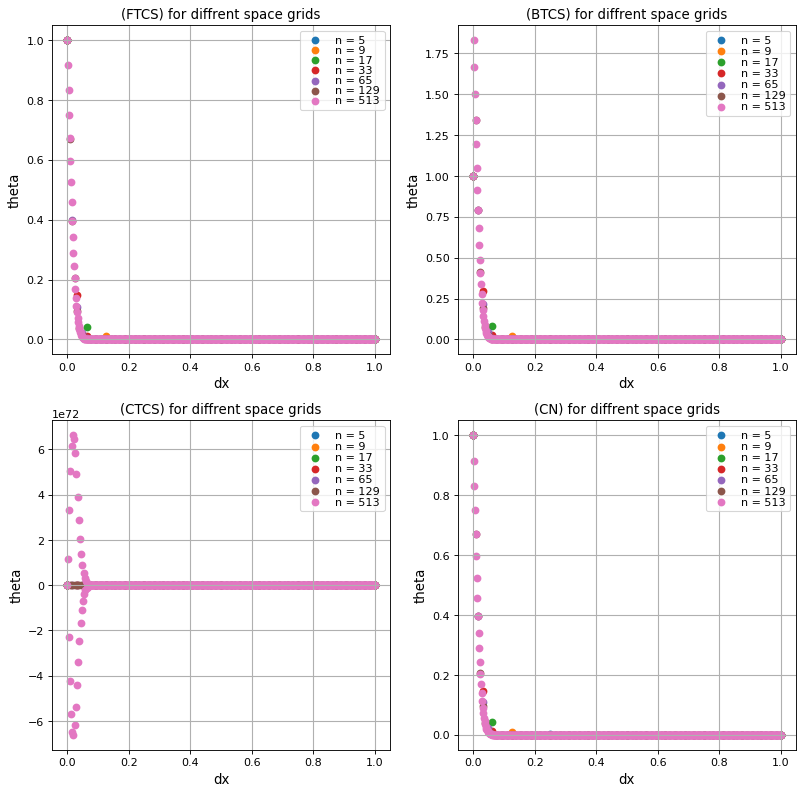

In [7]:
from matplotlib.pyplot import figure

figure(figsize=(12, 12), dpi=80)

plt.subplot(2, 2, 1)
for i in range(l):
    plt.scatter(sol_FTCS[i][0], sol_FTCS[i][1], linewidth=2, alpha=1, s=25, label= "n = " + str(n[i]))
plt.legend(scatterpoints=1, frameon=True, labelspacing=0.01)

plt.title('(FTCS) for diffrent space grids')
plt.xlabel('dx', fontsize = 12)
plt.ylabel('theta', fontsize = 12)
plt.grid(b=True, which='major', linewidth=1, linestyle='-')
plt.grid(b=True, which='minor', linewidth=1, linestyle='-')

#_____________________________________________________________________________________________________

plt.subplot(2, 2, 2)
for i in range(l):
    plt.scatter(sol_BTCS[i][0], sol_BTCS[i][1], linewidth=2, alpha=1, s=25, label= "n = " + str(n[i]))
plt.legend(scatterpoints=1, frameon=True, labelspacing=0.1)

plt.title('(BTCS) for diffrent space grids')
plt.xlabel('dx', fontsize = 12)
plt.ylabel('theta', fontsize = 12)

plt.grid(b=True, which='major', linewidth=1, linestyle='-')
plt.grid(b=True, which='minor', linewidth=1, linestyle='-')

plt.title('(BTCS) for diffrent space grids')

#_____________________________________________________________________________________________________

plt.subplot(2, 2, 3)
for i in range(l):
    plt.scatter(sol_CTCS[i][0], sol_CTCS[i][1], linewidth=2, alpha=1, s=25, label= "n = " + str(n[i]))
plt.legend(scatterpoints=1, frameon=True, labelspacing=0.1)

plt.title('(CTCS) for diffrent space grids')
plt.xlabel('dx', fontsize = 12)
plt.ylabel('theta', fontsize = 12)

plt.grid(b=True, which='major', linewidth=1, linestyle='-')
plt.grid(b=True, which='minor', linewidth=1, linestyle='-')

plt.title('(CTCS) for diffrent space grids')

#_____________________________________________________________________________________________________

plt.subplot(2, 2, 4)
for i in range(l):
    plt.scatter(sol_CN[i][0], sol_CN[i][1], linewidth=2, alpha=1, s=25, label= "n = " + str(n[i]))
plt.legend(scatterpoints=1, frameon=True, labelspacing=0.1)

plt.title('(CN) for diffrent space grids')
plt.xlabel('dx', fontsize = 12)
plt.ylabel('theta', fontsize = 12)

plt.grid(b=True, which='major', linewidth=1, linestyle='-')
plt.grid(b=True, which='minor', linewidth=1, linestyle='-')

plt.title('(CN) for diffrent space grids')

We can see that only Crank-Nicelson method is stable and FTCS can be unstabel in some time discretization

Text(0.5, 1.0, 'Solution Convergence(CN)')

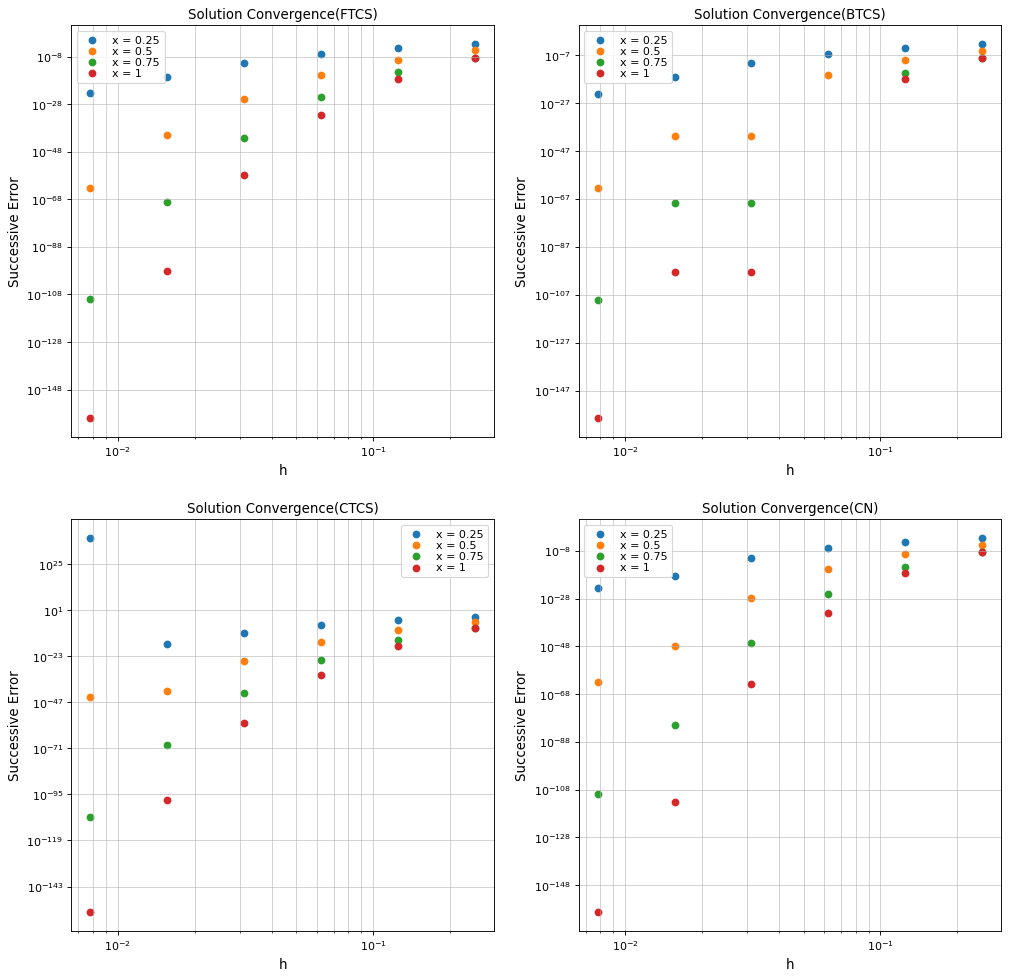

In [8]:
figure(figsize=(15, 15), dpi=80)

x = [0.25, 0.5, 0.75, 1]

l1 = len(x)
h = np.zeros(l-1)
for i in range(l-1):
    h[i] = 1/(n[i]-1)
    
def index(x,n):
    index = np.zeros(l)
    for i in range(l):
        index[i] = int(x/(1/(n[i]-1)))
    return index
#_____________________________________________________________________________________________________

error_s_FTCS = np.zeros((l1,l-1))

for j in range(l1):
    for i in range(l-1):
        error_s_FTCS[j,i] = abs(sol_FTCS[i+1][1][int(index(x[j],n)[i+1])] - sol_FTCS[i][1][int(index(x[j],n)[i])])

        
plt.subplot(2, 2, 1)        

plt.title('Solution Convergence', fontsize = 12)
plt.xlabel('h', fontsize = 12)
plt.ylabel('Successive Error', fontsize = 12)
plt.grid(b=True, which='major', linewidth=0.5, linestyle='-')
plt.grid(b=True, which='minor', linewidth=0.5, linestyle='-')

for i in range(l1):
    plt.scatter(h, error_s_FTCS[i,:], linewidth=2, alpha=1, s=25, label= "x = " + str(x[i]))
    
plt.legend(scatterpoints=1, frameon=True, labelspacing=0.1)

plt.xscale('log')

plt.yscale('log')

plt.title('Solution Convergence(FTCS)')

#_____________________________________________________________________________________________________

error_s_BTCS = np.zeros((l1,l-1))

for j in range(l1):
    for i in range(l-1):
        error_s_BTCS[j,i] = abs(sol_BTCS[i+1][1][int(index(x[j],n)[i+1])] - sol_BTCS[i][1][int(index(x[j],n)[i])])

        
plt.subplot(2, 2, 2)        

plt.title('Solution Convergence', fontsize = 12)
plt.xlabel('h', fontsize = 12)
plt.ylabel('Successive Error', fontsize = 12)
plt.grid(b=True, which='major', linewidth=0.5, linestyle='-')
plt.grid(b=True, which='minor', linewidth=0.5, linestyle='-')

for i in range(l1):
    plt.scatter(h, error_s_BTCS[i,:], linewidth=2, alpha=1, s=25, label= "x = " + str(x[i]))
    
plt.legend(scatterpoints=1, frameon=True, labelspacing=0.1)

plt.xscale('log')

plt.yscale('log')

plt.title('Solution Convergence(BTCS)')

#_____________________________________________________________________________________________________

error_s_CTCS = np.zeros((l1,l-1))

for j in range(l1):
    for i in range(l-1):
        error_s_CTCS[j,i] = abs(sol_CTCS[i+1][1][int(index(x[j],n)[i+1])] - sol_CTCS[i][1][int(index(x[j],n)[i])])

        
plt.subplot(2, 2, 3)        

plt.title('Solution Convergence', fontsize = 12)
plt.xlabel('h', fontsize = 12)
plt.ylabel('Successive Error', fontsize = 12)
plt.grid(b=True, which='major', linewidth=0.5, linestyle='-')
plt.grid(b=True, which='minor', linewidth=0.5, linestyle='-')

for i in range(l1):
    plt.scatter(h, error_s_CTCS[i,:], linewidth=2, alpha=1, s=25, label= "x = " + str(x[i]))
    
plt.legend(scatterpoints=1, frameon=True, labelspacing=0.1)

plt.xscale('log')

plt.yscale('log')

plt.title('Solution Convergence(CTCS)')

#_____________________________________________________________________________________________________

error_s_CN = np.zeros((l1,l-1))

for j in range(l1):
    for i in range(l-1):
        error_s_CN[j,i] = abs(sol_CN[i+1][1][int(index(x[j],n)[i+1])] - sol_CN[i][1][int(index(x[j],n)[i])])

        
plt.subplot(2, 2, 4)        

plt.title('Solution Convergence', fontsize = 12)
plt.xlabel('h', fontsize = 12)
plt.ylabel('Successive Error', fontsize = 12)
plt.grid(b=True, which='major', linewidth=0.5, linestyle='-')
plt.grid(b=True, which='minor', linewidth=0.5, linestyle='-')

for i in range(l1):
    plt.scatter(h, error_s_CN[i,:], linewidth=2, alpha=1, s=25, label= "x = " + str(x[i]))
    
plt.legend(scatterpoints=1, frameon=True, labelspacing=0.1)

plt.xscale('log')

plt.yscale('log')

plt.title('Solution Convergence(CN)')

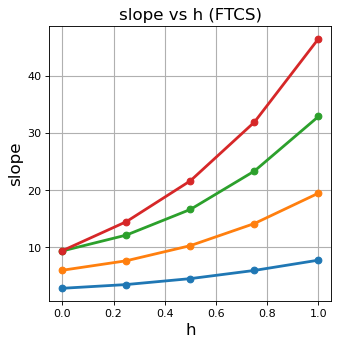

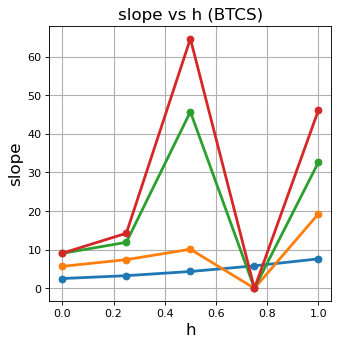

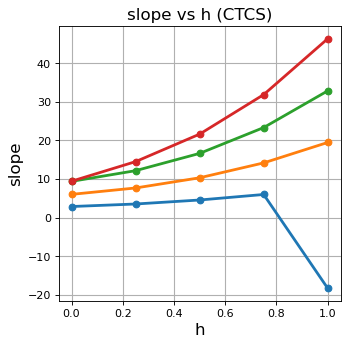

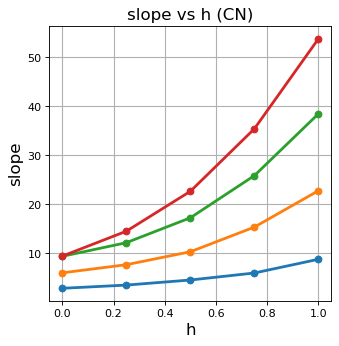

In [9]:
figure(figsize=(10, 10), dpi=80)

def slope(error_s,h,l1,l):
    slope = np.zeros((l1,l-2))
    for i in range (l1):
        for j in range (l-2):
            if (abs(error_s[i,j+1] - error_s[i,j]) == 0):
                slope[i,j] = 0
            else:
                slope[i,j] = np.log(abs(error_s[i,j+1] - error_s[i,j]))/np.log(abs(h[j+1]-h[j]))
    return slope

#_____________________________________________________________________________________________________


slope_FTCS = slope(error_s_FTCS,h,l1,l)

plt.subplot(2, 2, 1)
r = np.linspace(0,1,len(slope_FTCS[0,:]))
for i in range(l1):
    plt.plot(r, slope_FTCS[i,:], '-o', linewidth = 2.5, label= "x = " + str(x[i]))
# plt.legend(( 'x = 1', 'x = 0.75', 'x = 0.5', 'x = 0.25')), loc = 0)
plt.title('slope vs h (FTCS)', fontsize = 15)
plt.xlabel('h', fontsize = 15)
plt.ylabel('slope', fontsize = 15)
plt.grid(b=True, which='major', linewidth=1, linestyle='-')
plt.grid(b=True, which='minor', linewidth=1, linestyle='-')
plt.show()

#_____________________________________________________________________________________________________

figure(figsize=(10, 10), dpi=80)

slope_BTCS = slope(error_s_BTCS,h,l1,l)

plt.subplot(2, 2, 2)
for i in range(l1):
    plt.plot(r, slope_BTCS[i,:], '-o', linewidth = 2.5)
# plt.legend(( 'x = 1', 'x = 0.75', 'x = 0.5', 'x = 0.25')), loc = 0)

plt.title('slope vs h (BTCS)', fontsize = 15)
plt.xlabel('h', fontsize = 15)
plt.ylabel('slope', fontsize = 15)
plt.grid(b=True, which='major', linewidth=1, linestyle='-')
plt.grid(b=True, which='minor', linewidth=1, linestyle='-')
plt.show()

#_____________________________________________________________________________________________________

figure(figsize=(10, 10), dpi=80)

slope_CTCS = slope(error_s_CTCS,h,l1,l)

plt.subplot(2, 2, 3)

plt.title('slope vs h (CTCS)', fontsize = 15)
plt.xlabel('h', fontsize = 15)
plt.ylabel('slope', fontsize = 15)
plt.grid(b=True, which='major', linewidth=1, linestyle='-')
plt.grid(b=True, which='minor', linewidth=1, linestyle='-')
r = np.linspace(0,1,len(slope_CTCS[0,:]))
for i in range(l1):
    plt.plot(r, slope_CTCS[i,:], '-o', linewidth = 2.5)
# plt.legend(( 'x = 1', 'x = 0.75', 'x = 0.5', 'x = 0.25')), loc = 0)
plt.show()

#_____________________________________________________________________________________________________


figure(figsize=(10, 10), dpi=80)

slope_CN = slope(error_s_CN,h,l1,l)

plt.subplot(2, 2, 3)

plt.title('slope vs h (CN)', fontsize = 15)
plt.xlabel('h', fontsize = 15)
plt.ylabel('slope', fontsize = 15)
plt.grid(b=True, which='major', linewidth=1, linestyle='-')
plt.grid(b=True, which='minor', linewidth=1, linestyle='-')
r = np.linspace(0,1,len(slope_CN[0,:]))
for i in range(l1):
    plt.plot(r, slope_CN[i,:], '-o', linewidth = 2.5)
# plt.legend(( 'x = 1', 'x = 0.75', 'x = 0.5', 'x = 0.25')), loc = 0)
plt.show()

from this figures we can see converges of discretization methods that best method can used in solve problems is CN

In [10]:
n = [5, 9, 17, 33, 65] 
l = len(n)
n1 = [5, 9, 17, 33, 65]
# sol = [CN_solver(nx,nt,alpha,A_r,Bi) for nx in (n)]
sol = [[CN_solver(nx,nt,alpha,A_r,Bi) for nx in (n)]for nt in (n1)]